# Experiments

In [3]:
import os
import pickle as pkl
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
from skimage.color import rgb2ycbcr

## Plotting the dictionary

In [4]:
# addr for dictionaries
addr = "../data/dicts/"

dictonaries = {}
for dir in os.listdir(addr):
    if dir.endswith(".pkl"):
        dictonaries[dir] = pkl.load(open(addr + dir, "rb"))


In [9]:
for key, value in dictonaries.items():
    print(key, value.shape)

    # plot dictionary patches
    # Each dictionary is (x^2, 2048), create 2048 image patches where each image width is x
    # make a big plot of all the patches and save it
    x, y = value.shape

    patch_edge = int((x)**0.5)

    rows = int(y**0.5)+1
    cols = int(y**0.5)+1

    fig, ax = plt.subplots(rows, cols, figsize=(cols, rows))

    # set black background
    fig.patch.set_facecolor('white')

    # axis off
    for a in ax.flatten():
        a.axis('off')

    # set large spaces between patches
    plt.subplots_adjust(wspace=.1, hspace=.1)

    i = 0
    while(i < y):
        patch_x = i % cols
        patch_y = i // cols

        patch = value[:, i]

        # normalize patch
        patch = (patch - patch.min()) / (patch.max() - patch.min())

        # reshape patch
        patch = patch.reshape(patch_edge, patch_edge, order='F')

        # plot patch
        ax[patch_y, patch_x].imshow(patch, cmap='gray')


        i += 1

    # set plot title
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.suptitle(f'Dictionary: {patch_edge}x{patch_edge} patch, {y} Atoms', fontsize=54, color='black')
    plt.savefig(f"../data/dicts/viz/{'-'.join(key.split('.')[:-1])}.png")
    plt.close()





Dl_2048_US3_L0.1_PS3.pkl (36, 2048)
Dl_2048_US3_L0.1_PS5.pkl (100, 2048)
Dh_2048_US3_L0.1_PS3.pkl (9, 2048)
Dh_2048_US3_L0.1_PS5.pkl (25, 2048)


## Feature Extraction

In [2]:
def extract_lr_feat(img_lr):
    h, w = img_lr.shape
    img_lr_feat = np.zeros((h, w, 4))

    # First order gradient filters
    hf1 = [[-1, 0, 1], ] * 3
    vf1 = np.transpose(hf1)

    img_lr_feat[:, :, 0] = convolve2d(img_lr, hf1, 'same')
    img_lr_feat[:, :, 1] = convolve2d(img_lr, vf1, 'same')

    # Second order gradient filters
    hf2 = [[1, 0, -2, 0, 1], ] * 3
    vf2 = np.transpose(hf2)

    img_lr_feat[:, :, 2] = convolve2d(img_lr, hf2, 'same')
    img_lr_feat[:, :, 3] = convolve2d(img_lr, vf2, 'same')

    return img_lr_feat



In [6]:
# Loading a lr and hr image
lr_addr = "../data/val_lr/"
hr_addr = "../data/val_hr/"

# sampling random one image
lr_img_name = random.choice(os.listdir(lr_addr))
hr_img_name = lr_img_name 

lr_img = Image.open(lr_addr + lr_img_name)
hr_img = Image.open(hr_addr + hr_img_name)

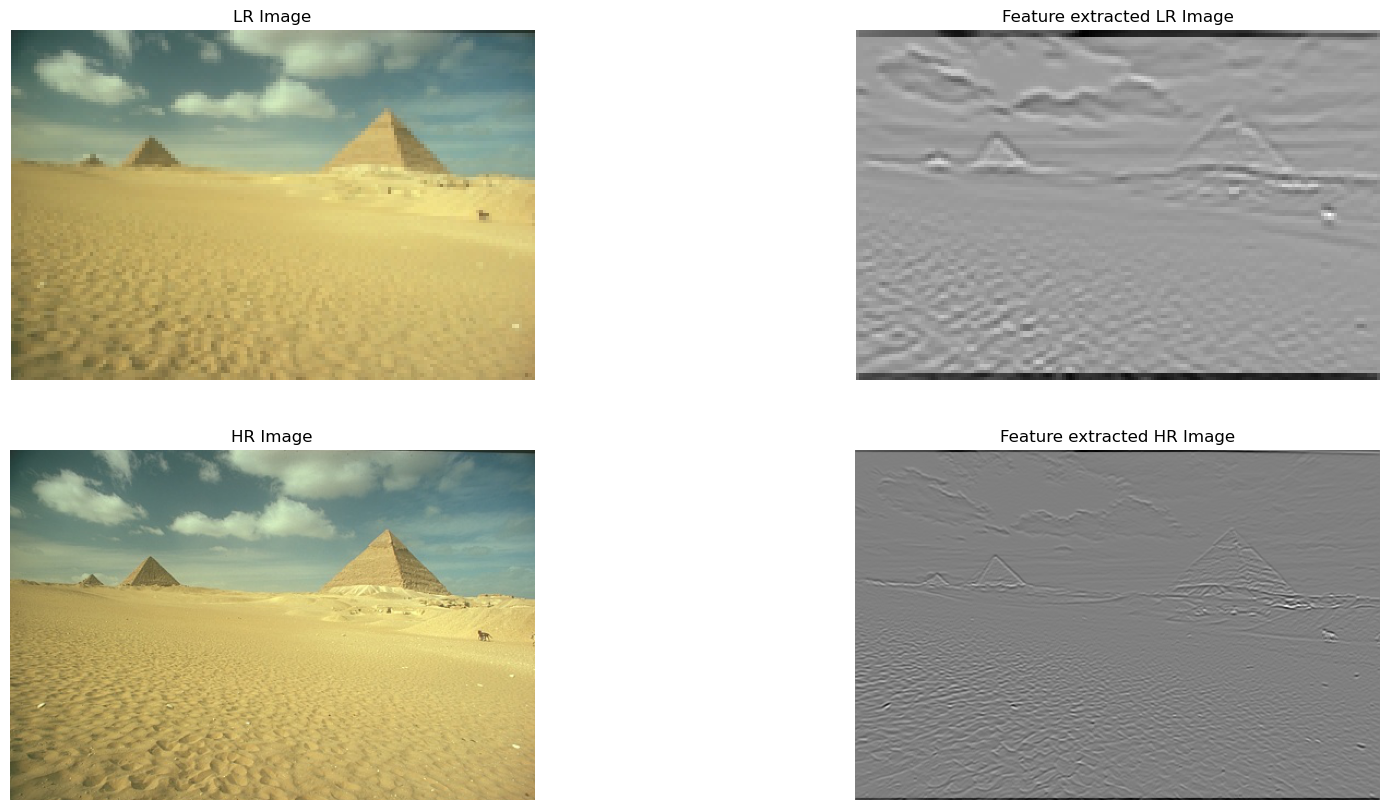

In [39]:
lr_img_y = rgb2ycbcr(np.array(lr_img))[:, :, 0]
hr_img_y = rgb2ycbcr(np.array(hr_img))[:, :, 0]

lr_img_y_feat = extract_lr_feat(lr_img_y)
hr_img_y_feat = extract_lr_feat(hr_img_y)

# normalize images
lr_img_y_feat = (lr_img_y_feat - lr_img_y_feat.min()) / (lr_img_y_feat.max() - lr_img_y_feat.min())
hr_img_y_feat = (hr_img_y_feat - hr_img_y_feat.min()) / (hr_img_y_feat.max() - hr_img_y_feat.min())

lr_img_y_feat = (lr_img_y_feat * 255).astype(np.uint8)
hr_img_y_feat = (hr_img_y_feat * 255).astype(np.uint8)

# plot lr and hr images
fig, ax = plt.subplots(2,2, figsize=(20, 10))

for a in ax.flatten():
    a.axis('off')

ax[0,0].imshow(lr_img)
ax[0,0].set_title("LR Image")
ax[1,0].imshow(hr_img)
ax[1,0].set_title("HR Image")

ax[0,1].imshow(lr_img_y_feat[:,:,3], cmap='gray')
ax[0,1].set_title("Feature extracted LR Image")
ax[1,1].imshow(hr_img_y_feat[:,:,3], cmap='gray')
ax[1,1].set_title("Feature extracted HR Image")
plt.show()

## Comparing given code result with exp1 (added c(X - X0)) 

In [67]:
import skimage.metrics as sm
import skimage.color as sc


addr = "../data/results/2048_US3_L0.1_PS3_295087"
true_addr = addr + "/3HR.png"
given_addr = addr + "/2SR.png"
exp1_addr = "../data/results/2048_US3_L0.1_PS3exp1_295087/2SR.png"

true_img = Image.open(true_addr)
given_img = Image.open(given_addr)
exp1_img = Image.open(exp1_addr)

true_img_y = sc.rgb2ycbcr(np.array(true_img))[:, :, 0]
given_img_y = sc.rgb2ycbcr(np.array(given_img))[:, :, 0]
exp1_img_y = sc.rgb2ycbcr(np.array(exp1_img))[:, :, 0]

# given_imgmax = given_img_y.max()
# given_imgmin = given_img_y.min()

# exp1_imgmax = exp1_img_y.max()
# exp1_imgmin = exp1_img_y.min()

# print(f"Given Image Max: {given_imgmax}, Min: {given_imgmin}"
#       f"Exp1 Image Max: {exp1_imgmax}, Min: {exp1_imgmin}")

t_g_ssim = sm.structural_similarity(true_img_y, given_img_y, data_range=given_img_y.max() - given_img_y.min())
t_e_ssim = sm.structural_similarity(true_img_y, exp1_img_y, data_range=exp1_img_y.max() - exp1_img_y.min())
g_e_ssim = sm.structural_similarity(given_img_y, exp1_img_y, data_range=exp1_img_y.max() - exp1_img_y.min())

print(f"True vs Given SSIM: {t_g_ssim}")
print(f"True vs Exp1 SSIM: {t_e_ssim}")
print(f"Given vs Exp1 SSIM: {g_e_ssim}")

True vs Given SSIM: 0.7478087102620758
True vs Exp1 SSIM: 0.7478087102620758
Given vs Exp1 SSIM: 1.0


## Making collages

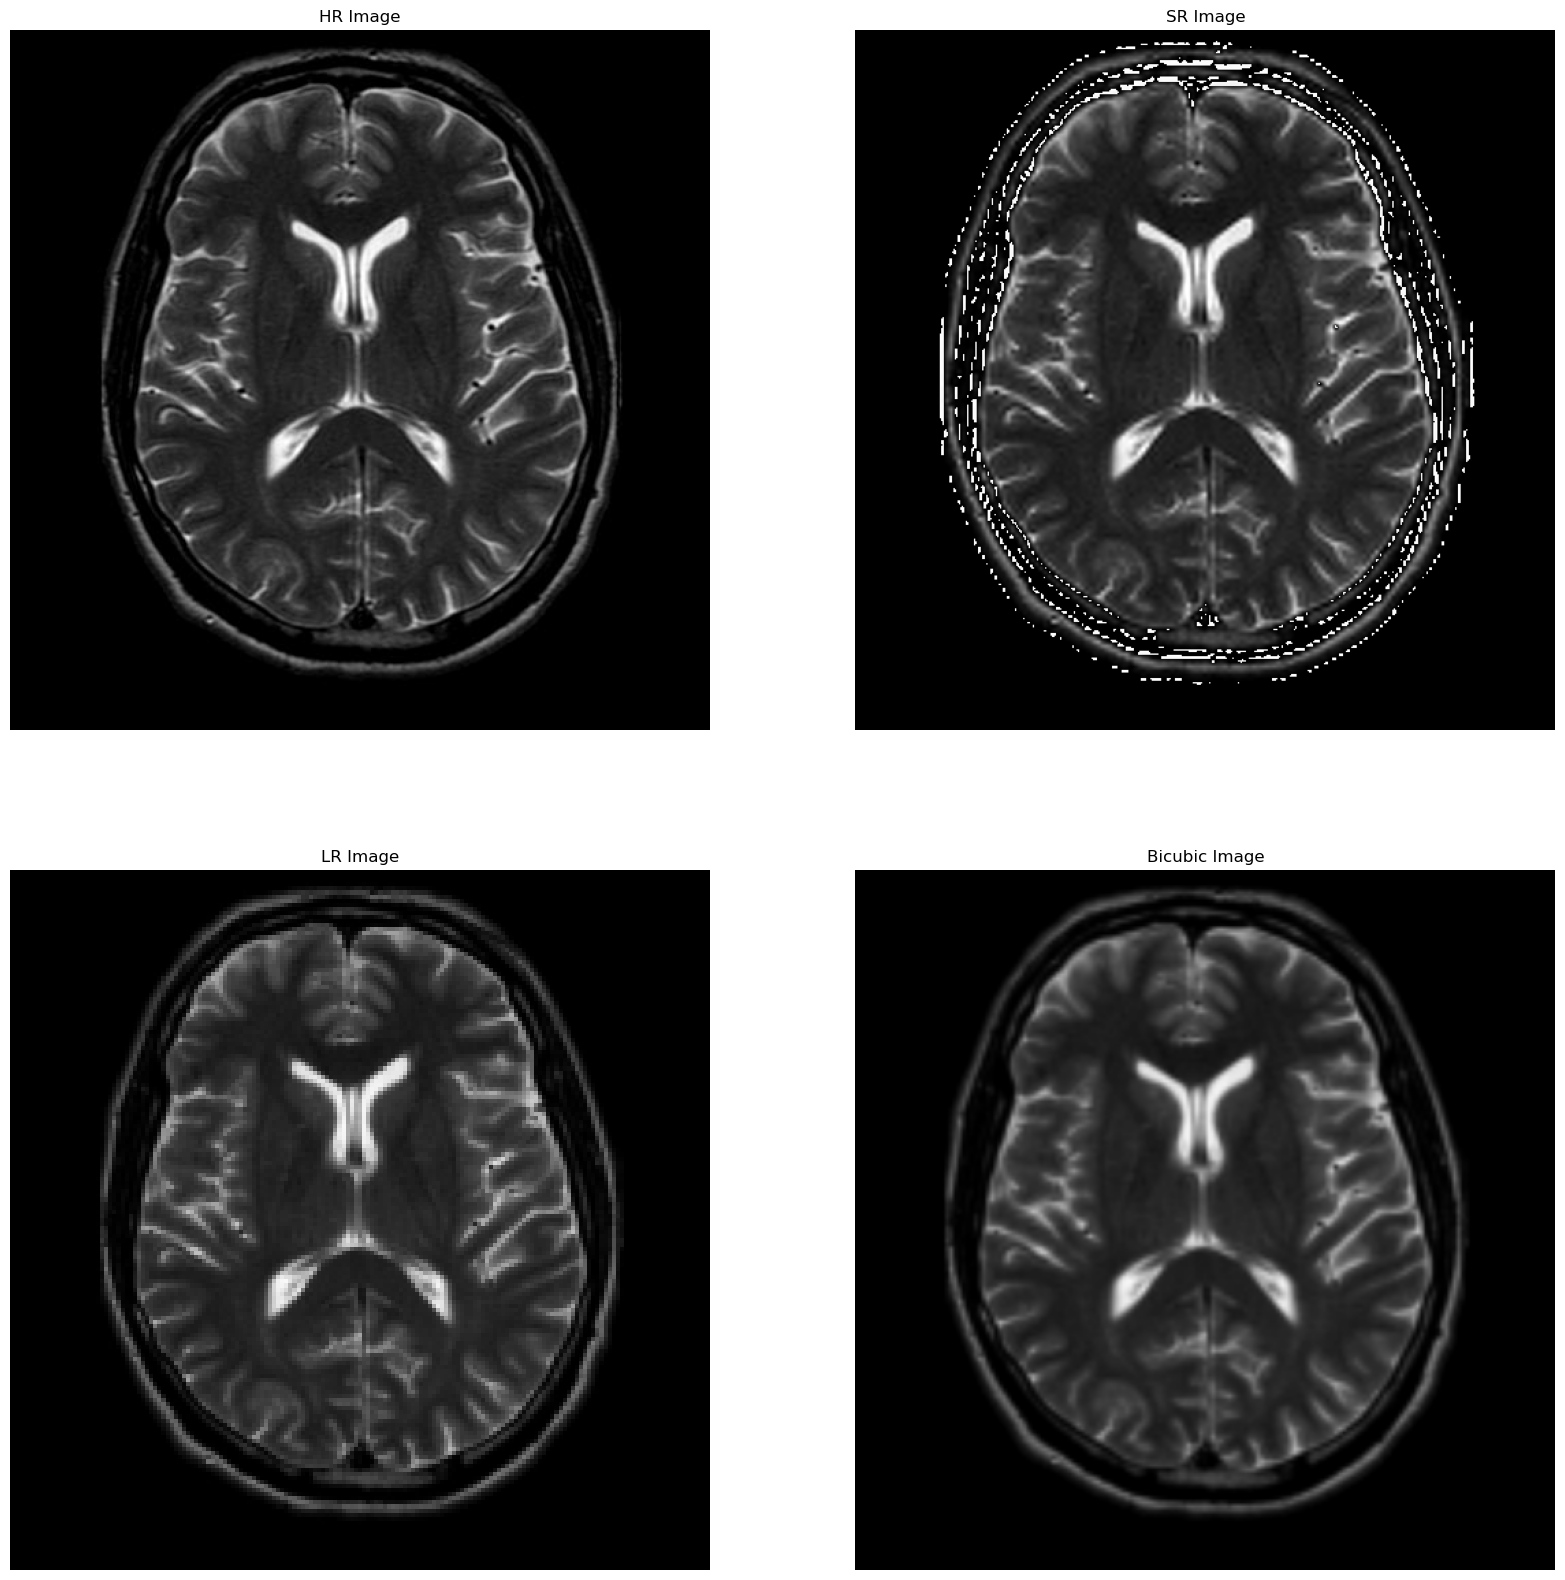

In [6]:
results_dir = os.listdir("../data/results/")
directories = [d for d in results_dir if 'brain' in d]


d = "../data/results/" + directories[0]

hr = Image.open(d + "/3HR.png")
lr = Image.open(d + "/LR.png")
sr = Image.open(d + "/2SR.png")
bicubic = Image.open(d + "/1bicubic.png")

fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for a in ax.flatten():
    a.axis('off')

ax[0, 0].imshow(hr)
ax[0, 0].set_title("HR Image")

ax[1, 0].imshow(lr)
ax[1, 0].set_title("LR Image")

ax[0, 1].imshow(sr)
ax[0, 1].set_title("SR Image")

ax[1, 1].imshow(bicubic)
ax[1, 1].set_title("Bicubic Image")

plt.savefig(d + "/viz.png")


## ResNet18 Layers and Visualization

In [5]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

def extract_cnn_features(img_path):
    # Load a pretrained ResNet model
    model = models.resnet18(pretrained=True)
    # Remove the final fully connected layer to use the model as a feature extractor
    model = torch.nn.Sequential(*(list(model.children())[:-1]))
    model.eval()  # Set the model to evaluation mode

    # Define the preprocessing transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the image, apply the transformation
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

    # Use the model to extract features
    with torch.no_grad():  # Ensure no gradients are computed to save memory
        features = model(img_tensor)

    # Flatten the features to fit the expected output format
    features = features.view(features.size(0), -1)
    return features.numpy()  # Convert to NumPy array for further processing if necessary

# Example usage:
# features = extract_cnn_features('path_to_your_image.jpg')


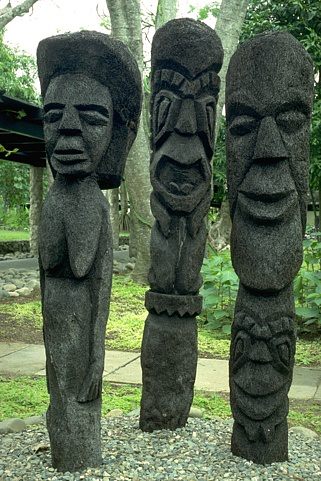

In [9]:
img_name = "101085.jpg"
hr = Image.open("../data/val_hr/" + img_name)
lr = Image.open("../data/val_lr/" + img_name)


In [15]:
models.resnet18(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def visualize_feature_maps(img_path, layer_name='layer1'):
    # Load a pretrained ResNet model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.eval()  # Set the model to evaluation mode

    # Hook to grab the feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Attach the hook to the desired layer
    getattr(model, layer_name).register_forward_hook(get_activation(layer_name))

    # Define the preprocessing transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load and preprocess the image
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

    # Pass the image through the model
    with torch.no_grad():
        _ = model(img_tensor)

    # Get the feature maps
    feature_maps = activation[layer_name].squeeze(0)

    n = int(feature_maps.size(0)**0.5 + 1)

    # Plot the image and the feature maps
    fig, axes = plt.subplots(n, n, figsize=(20, 20))
    ax = axes.ravel()
    for idx in range(n*n):
        ax[idx].axis('off')

    # Plot the original image
    img = Image.open(img_path)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    print(f'feature shape: {feature_maps.shape}')

    # Plot each feature map
    for i, fmap in enumerate(feature_maps):
        ax[i + 1].imshow(fmap.cpu().numpy(), cmap='gray')
        ax[i + 1].set_title(f'Feature Map {i + 1}')

    




In [75]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torch.nn.functional import interpolate

def extract_cnn_features(img_path):
    # Load a pretrained ResNet model with the best available pretrained weights
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    # Extract only the first layer
    first_layer = torch.nn.Sequential(*(list(model.children())[:4]))  # Include until the first pooling to preserve spatial dimensions
    model = torch.nn.Sequential(first_layer)
    model.eval()  # Set the model to evaluation mode

    # Define the preprocessing transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std)
    ])

    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')  # Ensure image is RGB
    img_tensor = transform(img).unsqueeze(0)  # Add a batch dimension

    # Get the original image size (height, width)
    original_size = img.size[::-1]

    # Pass the image through the model
    with torch.no_grad():
        features = model(img_tensor)
    print(features.shape)
    # Resize feature maps to the size of the original image
    features_resized = interpolate(features, size=original_size, mode='bilinear', align_corners=False)

    # Convert to numpy array for further processing if necessary
    features_np = features_resized.squeeze(0).permute(1, 2, 0).numpy()

    return features_np




In [74]:
list(resnet18().children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [60]:
import os
import random

img_names = os.listdir("../data/val_hr/")
random_img =  random.choice(img_names)

In [76]:
features = extract_cnn_features("../data/val_hr/" + random_img)

torch.Size([1, 64, 81, 121])


In [77]:
features.shape

(321, 481, 64)

In [67]:
Image.open("../data/val_hr/" + random_img).size

(481, 321)

(321, 481, 64)

feature shape: torch.Size([64, 56, 56])


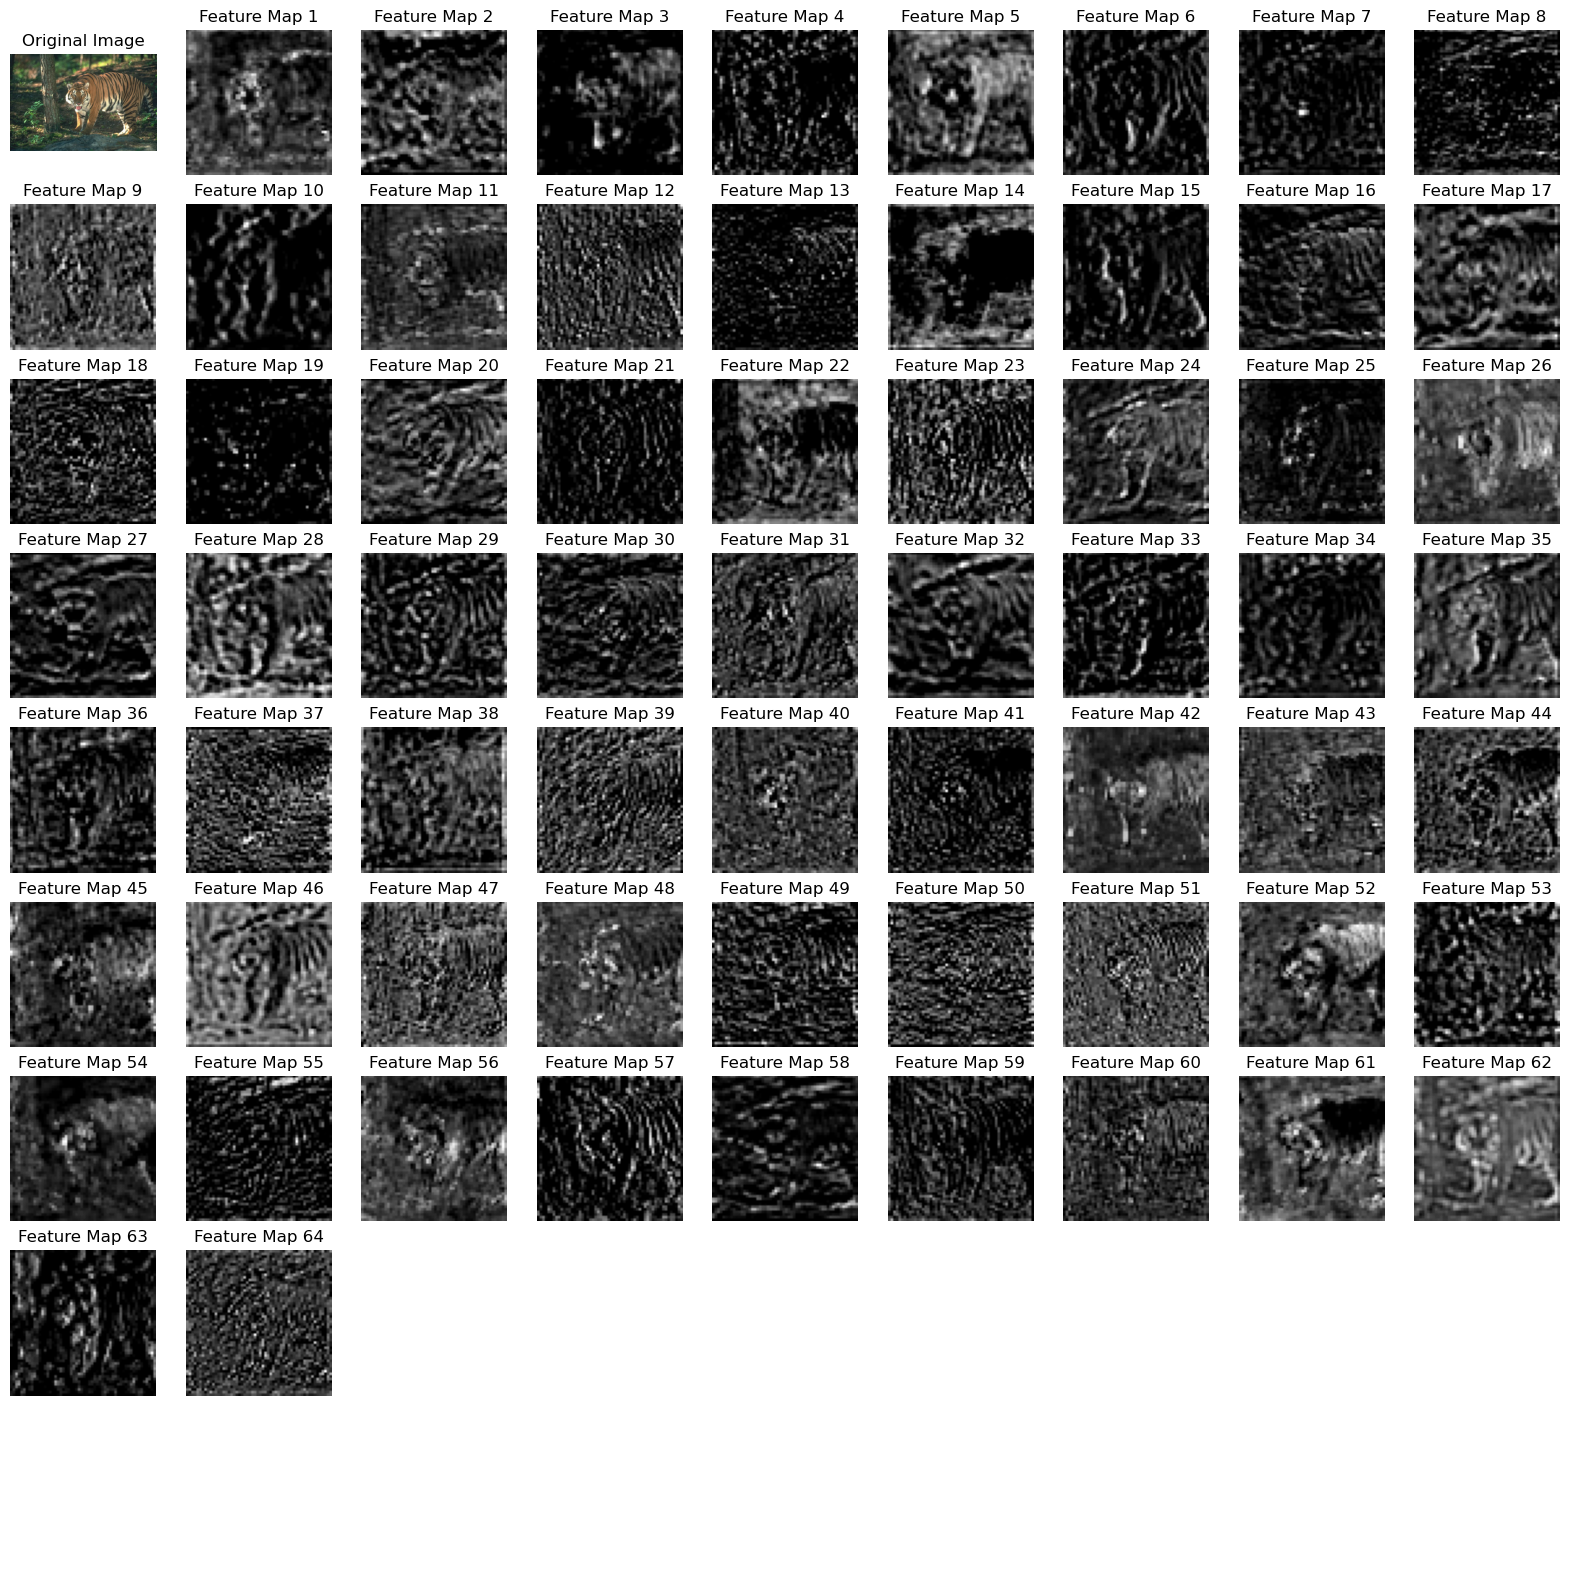

In [57]:
visualize_feature_maps("../data/val_hr/" + random_img)